**In the notebook I use multiple deep learning models like LSTM and Time Series Transformer to predict the stock market price. Further I will use traditional statistics model like ARIMA to predict the prices and compare the result**

Let's start by installing all the required Libraries in one place

In [1]:
%%capture
!pip install fyers_apiv3
!pip install pyotp
!pip install pandas-ta
!pip install torch
!pip install scikit-learn

Now, Importing all the required Libraries in one place

In [2]:
from fyers_apiv3 import fyersModel
import datetime
from datetime import timedelta
import time
import os
import pyotp
import requests
import json
import math
import pytz
from urllib.parse import parse_qs,urlparse
import warnings
import pandas as pd
import base64
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from kaggle_secrets import UserSecretsClient

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

First, I Authenticate Fyers API to get stock market data

In [3]:


user_secrets = UserSecretsClient()
client_id = user_secrets.get_secret("client_id")
FY_ID = user_secrets.get_secret("FY_ID")
PIN = user_secrets.get_secret("PIN")
redirect_url = user_secrets.get_secret("redirect_url")
secret_key = user_secrets.get_secret("secret_key")
TOTP_KEY = user_secrets.get_secret("TOTP_KEY")


def getEncodedString(string):
    string = str(string)
    base64_bytes = base64.b64encode(string.encode("ascii"))
    return base64_bytes.decode("ascii")
  



URL_SEND_LOGIN_OTP="https://api-t2.fyers.in/vagator/v2/send_login_otp_v2"
res = requests.post(url=URL_SEND_LOGIN_OTP, json={"fy_id":getEncodedString(FY_ID),"app_id":"2"}).json()


if datetime.datetime.now().second % 30 > 27 : sleep(5)
URL_VERIFY_OTP="https://api-t2.fyers.in/vagator/v2/verify_otp"
res2 = requests.post(url=URL_VERIFY_OTP, json= {"request_key":res["request_key"],"otp":pyotp.TOTP(TOTP_KEY).now()}).json()  



ses = requests.Session()
URL_VERIFY_OTP2="https://api-t2.fyers.in/vagator/v2/verify_pin_v2"
payload2 = {"request_key": res2["request_key"],"identity_type":"pin","identifier":getEncodedString(PIN)}
res3 = ses.post(url=URL_VERIFY_OTP2, json= payload2).json()
 


ses.headers.update({
    'authorization': f"Bearer {res3['data']['access_token']}"
})


TOKENURL="https://api-t1.fyers.in/api/v3/token"
payload3 = {"fyers_id":FY_ID,
           "app_id":client_id[:-4],
           "redirect_uri":redirect_url,
           "appType":"100","code_challenge":"",
           "state":"None","scope":"","nonce":"","response_type":"code","create_cookie":True}

res3 = ses.post(url=TOKENURL, json= payload3).json()  



url = res3['Url']
parsed = urlparse(url)
auth_code = parse_qs(parsed.query)['auth_code'][0]
auth_code

grant_type = "authorization_code" 

response_type = "code"  

session = fyersModel.SessionModel(
    client_id=client_id,
    secret_key=secret_key, 
    redirect_uri=redirect_url, 
    response_type=response_type, 
    grant_type=grant_type
)

# Set the authorization code in the session object
session.set_token(auth_code)

# Generate the access token using the authorization code
response = session.generate_token()

# Print the response, which should contain the access token and other details
#print(response)


access_token = response['access_token']

# Initialize the FyersModel instance with your client_id, access_token, and enable async mode
fyers = fyersModel.FyersModel(client_id=client_id, is_async=False, token=access_token, log_path=os.getcwd())


Now import the reliance and hdfc stock price data using fyers API.

In [4]:

def generate_data(symbol, timeframe):
    
    
    df = pd.DataFrame(columns=["timestamp","date", "open", "high", "low", "close", "volume"])
    
    # Try to get last 10 years data in 15m time frame
    
    for i in range(40):
        end_date = datetime.datetime.now() -i*datetime.timedelta(days=90)
        start_date = end_date - datetime.timedelta(days=90)
        
        # Convert datetime to Unix timestamp (in seconds)
        start_time = int(start_date.timestamp())
        end_time = int(end_date.timestamp())
        
        # Define interval = 15 
        data = {
        "symbol": symbol,
        "resolution": timeframe,
        "date_format": "0",
        "range_from": str(start_time),
        "range_to": str(end_time),
        "cont_flag": "1"
        }
        
        # Call the API
        response = fyers.history(data=data)
        
        # Check response
        if response.get("code") == 200:
            candles = response["candles"]
            df1 = pd.DataFrame(candles, columns=["timestamp", "open", "high", "low", "close", "volume"])
            df1["date"] = pd.to_datetime(df1["timestamp"], unit='s')
            df = pd.concat([df1,df], ignore_index=True)
        
        else:
            print("Error fetching data:", response)
        if i%10==0:
            time.sleep(1)
            
    return df

df_reliance = generate_data("NSE:RELIANCE-EQ", "15")
df_hdfc = generate_data("NSE:HDFCBANK-EQ", "15")

print(df_reliance.head())
print(df_hdfc.head())


Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
Error fetching data: {'candles': [], 'message': '', 's': 'no_data'}
    timestamp    open    high     low   close  v

Now add technical analysis features to the stock_data

In [5]:
def add_ta_features(df):
    df["EMA_5"] = df["close"].ewm(span=5, adjust=False).mean()
    df["EMA_9"] = df["close"].ewm(span=9, adjust=False).mean()
    df["EMA_15"] = df["close"].ewm(span=15, adjust=False).mean()
    
    df.ta.supertrend(length=10, multiplier=3.0, append=True)
    
    df["RSI"] = df.ta.rsi(length=14)

    # ATR for volatility
    df["ATR"] = ta.atr(high=df["high"], low=df["low"], close=df["close"], length=14)

    # Calculate MACD
    macd = ta.macd(df["close"], fast=12, slow=26, signal=9)
    
    # Merge MACD columns into the DataFrame
    df = df.join(macd)
    
    # Optional: Rename columns for clarity
    df.rename(columns={
        'MACD_12_26_9': 'MACD',
        'MACDs_12_26_9': 'MACD_signal',
        'MACDh_12_26_9': 'MACD_histogram'
    }, inplace=True)

    return df


df_reliance = add_ta_features(df_reliance)
df_hdfc = add_ta_features(df_hdfc)


print(df_reliance.head())
print(df_hdfc.head())




    timestamp    open    high     low   close  volume                date  \
0  1499053500  343.99  343.99  339.80  340.88  198292 2017-07-03 03:45:00   
1  1499054400  340.88  341.70  340.21  340.50   44768 2017-07-03 04:00:00   
2  1499055300  340.50  340.66  339.78  340.36   47156 2017-07-03 04:15:00   
3  1499056200  340.31  340.78  340.20  340.62   36342 2017-07-03 04:30:00   
4  1499057100  340.62  341.01  339.66  340.18   72088 2017-07-03 04:45:00   

        EMA_5       EMA_9      EMA_15  SUPERT_10_3.0  SUPERTd_10_3.0  \
0  340.880000  340.880000  340.880000            0.0               1   
1  340.753333  340.804000  340.832500            NaN               1   
2  340.622222  340.715200  340.773438            NaN               1   
3  340.621481  340.696160  340.754258            NaN               1   
4  340.474321  340.592928  340.682476            NaN               1   

   SUPERTl_10_3.0  SUPERTs_10_3.0  RSI  ATR  MACD  MACD_histogram  MACD_signal  
0             NaN      

Now add time features to dataframe

In [6]:
day_dict = {"Monday": 1,
            "Tuesday": 2,
            "Wednesday": 3,
            "Thursday" : 4,
            "Friday" : 5,
            "Saturday": 6,
            "Sunday" : 7
           }
day = 60*60*24
year = 365.2425*day

def add_time_features(df):
    df['day'] = df['date'].dt.day_name()
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df["day"] = df["day"].map(day_dict)

    ## Add nifty expiry day features
    df['expiry_day'] = 0 # Initialize with a default value
    df.loc[(df['day'] == 4) & (df['year'] > 2019), 'expiry_day'] = 1
    df['Seconds'] = df['date'].map(pd.Timestamp.timestamp)
    df['Day sin'] = np.sin(df['Seconds'] * (2* np.pi / day))
    df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
    df['Year sin'] = np.sin(df['Seconds'] * (2 * np.pi / year))
    df['Year cos'] = np.cos(df['Seconds'] * (2 * np.pi / year))

    return df


df_reliance = add_time_features(df_reliance)
df_hdfc = add_time_features(df_hdfc)

print(df_reliance.head())
print(df_hdfc.head())

    timestamp    open    high     low   close  volume                date  \
0  1499053500  343.99  343.99  339.80  340.88  198292 2017-07-03 03:45:00   
1  1499054400  340.88  341.70  340.21  340.50   44768 2017-07-03 04:00:00   
2  1499055300  340.50  340.66  339.78  340.36   47156 2017-07-03 04:15:00   
3  1499056200  340.31  340.78  340.20  340.62   36342 2017-07-03 04:30:00   
4  1499057100  340.62  341.01  339.66  340.18   72088 2017-07-03 04:45:00   

        EMA_5       EMA_9      EMA_15  SUPERT_10_3.0  SUPERTd_10_3.0  \
0  340.880000  340.880000  340.880000            0.0               1   
1  340.753333  340.804000  340.832500            NaN               1   
2  340.622222  340.715200  340.773438            NaN               1   
3  340.621481  340.696160  340.754258            NaN               1   
4  340.474321  340.592928  340.682476            NaN               1   

   SUPERTl_10_3.0  SUPERTs_10_3.0  RSI  ATR  MACD  MACD_histogram  \
0             NaN             NaN  

Now Check the correlation of "close" price of data with all featues

In [7]:
df_reliance.describe()

,open,high,low,close,date,EMA_5,EMA_9,EMA_15,SUPERT_10_3.0,SUPERTd_10_3.0,SUPERTl_10_3.0,SUPERTs_10_3.0,RSI,ATR,MACD,MACD_histogram,MACD_signal,day,month,year,expiry_day,Seconds,Day sin,Day cos,Year sin,Year cos
count,49807.000000,49807.000000,49807.000000,49807.000000,49807,49807.000000,49807.000000,49807.000000,49798.000000,49807.000000,26733.000000,23064.000000,49793.000000,49793.000000,49782.000000,49774.000000,49774.000000,49807.000000,49807.000000,49807.000000,49807.000000,4.980700e+04,49807.000000,49807.000000,49807.000000,49807.000000
mean,994.196668,995.936784,992.335939,994.168437,2021-07-15 09:10:34.934848512,994.126183,994.083850,994.020283,993.771641,0.073865,976.842135,1013.437364,50.608627,3.685919,0.148522,-0.000279,0.148615,3.003413,6.507278,2021.037846,0.139639,1.626340e+09,0.874324,-0.174716,-0.005053,-0.010408
min,340.180000,340.660000,339.660000,340.180000,2017-07-03 03:45:00,340.474321,340.592928,340.682476,0.000000,-1.000000,339.621091,378.433859,5.091744,0.523264,-28.070243,-12.654028,-24.632465,1.000000,1.000000,2017.000000,0.000000,1.499054e+09,-0.382683,-1.000000,-1.000000,-1.000000
25%,635.245000,636.345000,634.030000,635.130000,2019-07-10 03:52:30,635.227788,635.104884,634.942683,633.975534,-1.000000,625.710732,649.370679,40.705488,2.465629,-1.749229,-0.481221,-1.687633,2.000000,4.000000,2019.000000,0.000000,1.562731e+09,0.831470,-0.555570,-0.695332,-0.741432
50%,1107.530000,1109.630000,1105.500000,1107.500000,2021-07-15 04:45:00,1107.501520,1107.427293,1107.211818,1105.706324,1.000000,1076.453039,1140.503543,50.691542,3.534601,0.115111,-0.017129,0.116482,3.000000,7.000000,2021.000000,0.000000,1.626324e+09,0.923880,-0.195090,-0.011776,-0.020688
75%,1270.080000,1272.400000,1268.100000,1270.130000,2023-07-20 08:37:30,1270.395272,1270.448106,1270.094249,1269.758343,1.000000,1258.364235,1283.047331,60.316514,4.636112,1.955391,0.473249,1.863663,4.000000,9.000000,2023.000000,0.000000,1.689842e+09,0.980785,0.195090,0.680175,0.716302
max,1607.930000,1608.800000,1604.080000,1607.850000,2025-07-25 09:45:00,1603.891577,1601.284892,1599.588158,1601.511256,1.000000,1588.938850,1601.511256,94.152751,21.395213,21.987238,7.742454,20.481190,7.000000,12.000000,2025.000000,1.000000,1.753437e+09,1.000000,0.608761,1.000000,1.000000
std,349.169597,349.628814,348.700124,349.161084,NaN,349.160358,349.161488,349.162313,349.163364,0.997278,350.874017,346.086409,13.951165,1.679328,3.715538,1.027853,3.533586,1.416111,3.438922,2.364072,0.346616,7.353668e+07,0.129775,0.433814,0.696488,0.717489


In [8]:
df_hdfc.describe()

,open,high,low,close,date,EMA_5,EMA_9,EMA_15,SUPERT_10_3.0,SUPERTd_10_3.0,SUPERTl_10_3.0,SUPERTs_10_3.0,RSI,ATR,MACD,MACD_histogram,MACD_signal,day,month,year,expiry_day,Seconds,Day sin,Day cos,Year sin,Year cos
count,49801.000000,49801.000000,49801.000000,49801.000000,49801,49801.000000,49801.000000,49801.000000,49792.000000,49801.000000,25883.000000,23908.000000,49787.000000,49787.000000,49776.000000,49768.000000,49768.000000,49801.000000,49801.000000,49801.000000,49801.000000,4.980100e+04,49801.000000,49801.000000,49801.000000,49801.000000
mean,1360.560903,1362.759654,1358.260532,1360.555839,2021-07-15 13:49:26.127186176,1360.508470,1360.461108,1360.390024,1360.461537,0.039859,1361.017705,1359.916328,50.742447,4.627822,0.165688,-0.000175,0.165868,3.003534,6.507560,2021.038353,0.139676,1.626357e+09,0.874342,-0.174636,-0.005110,-0.010321
min,745.000000,759.250000,738.750000,745.000000,2017-07-03 03:45:00,758.953275,764.758105,770.869975,0.000000,-1.000000,765.102593,800.202792,6.766597,1.158111,-38.054564,-12.040292,-32.652680,1.000000,1.000000,2017.000000,0.000000,1.499054e+09,-0.382683,-1.000000,-1.000000,-1.000000
25%,1071.070000,1073.000000,1068.930000,1071.150000,2019-07-10 05:00:00,1070.560610,1070.054140,1069.578055,1070.791902,-1.000000,1065.833540,1073.895473,41.465043,3.286792,-2.003794,-0.606577,-1.922116,2.000000,4.000000,2019.000000,0.000000,1.562735e+09,0.831470,-0.555570,-0.695381,-0.741353
50%,1426.250000,1428.700000,1423.800000,1426.200000,2021-07-15 05:45:00,1426.445343,1426.445336,1426.567417,1424.850144,1.000000,1429.113104,1420.111451,50.769732,4.377067,0.191350,-0.000525,0.191191,3.000000,7.000000,2021.000000,0.000000,1.626328e+09,0.923880,-0.195090,-0.011776,-0.020610
75%,1599.750000,1602.000000,1597.150000,1599.750000,2023-07-20 09:00:00,1599.720797,1600.049505,1600.399284,1600.813270,1.000000,1599.244977,1601.812431,60.106806,5.557354,2.345380,0.607441,2.247374,4.000000,9.000000,2023.000000,0.000000,1.689844e+09,0.980785,0.195090,0.680099,0.716460
max,2037.700000,2037.700000,2026.000000,2029.400000,2025-07-25 09:45:00,2024.963678,2023.770284,2021.622420,2031.432571,1.000000,2016.432075,2031.432571,97.404788,25.461040,50.348402,21.668781,40.206754,7.000000,12.000000,2025.000000,1.000000,1.753437e+09,1.000000,0.608761,1.000000,1.000000
std,293.289276,293.581527,293.010883,293.298292,NaN,293.259157,293.224146,293.171152,293.029392,0.999215,293.929759,291.930162,13.451328,2.040509,4.508549,1.305202,4.266201,1.416011,3.439101,2.363846,0.346654,7.352908e+07,0.129727,0.433825,0.696497,0.717482


In [9]:
df_reliance.corr()["close"]

timestamp         0.937245
open              0.999969
high              0.999985
low               0.999983
close             1.000000
volume           -0.019393
date              0.937245
EMA_5             0.999969
EMA_9             0.999931
EMA_15            0.999869
SUPERT_10_3.0     0.999559
SUPERTd_10_3.0   -0.027681
SUPERTl_10_3.0    0.999908
SUPERTs_10_3.0    0.999888
RSI              -0.013435
ATR               0.558249
MACD              0.014550
MACD_histogram   -0.002993
MACD_signal       0.016273
day               0.002712
month            -0.010246
year              0.925029
expiry_day        0.226165
Seconds           0.937245
Day sin           0.000536
Day cos           0.000998
Year sin          0.020338
Year cos         -0.054626
Name: close, dtype: float64

Define the function to generate sliding window

In [10]:
def generate_X_Y(numpy_arr, window_size=10):
  X = []
  y = []
  for i in range(len(numpy_arr)-window_size):
    row = numpy_arr[i:i+window_size,:]
    X.append(row)
    label = numpy_arr[i+window_size,0]
    y.append(label)
  return np.array(X), np.array(y)

Now, I will def a function to filter the important features, standardise the data using StandardScalar, and add add time related data. Split the data into Training, Validation and test dataset.(70%, 10%, 20%)

In [11]:
def split_data(df):
    final_data = df[['close','EMA_5','EMA_9','EMA_15','expiry_day','SUPERTd_10_3.0','RSI','MACD',"ATR"]]
    final_data.dropna(inplace=True)

    X = final_data.to_numpy()
    
    train_size = int(0.8*X.shape[0])
    X_train = X[:train_size,:]
    X_test = X[train_size:,:]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    remaining_columns = df[['Day sin','Day cos','Year sin',"Year sin"]].to_numpy()
    X_train = np.append(X_train,remaining_columns[25:train_size+25],axis=1)
    X_test = np.append(X_test,remaining_columns[(train_size+25):],axis=1)

    X_train, Y_train = generate_X_Y(X_train)
    X_test, Y_test = generate_X_Y(X_test)
    
    val_index = int(0.7*X.shape[0])
    X_val, Y_val = X_train[val_index:,:], Y_train[val_index:]
    return X_train[:val_index,:], Y_train[:val_index], X_val, Y_val, X_test, Y_test, scaler



Now let's define the LSTM > Model

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 8)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(8, 1)

    def forward(self, x):
        out, _ = self.lstm(x)      # out: (batch, seq_len, hidden)
        out = out[:, -1, :]        # last time step
        out = self.linear(out)
        out = self.relu(out)
        return self.fc(out)

Define the training function

In [13]:
def train(X_train, Y_train, X_val, Y_val):
    n_features =X_train.shape[2]  ## The number of columns in data

    model = LSTMModel(input_size=n_features).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    for epoch in range(100):
        model.train()
        pred = model(X_train)
        loss = loss_fn(pred, Y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if epoch % 10 == 0:
            model.eval()
            val_loss = loss_fn(model(X_val), Y_val)
            print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

    return model


In [14]:
def validate(model, X_test, Y_test, scaler, heading):
    model.eval()
    with torch.no_grad():
        pred_scaled = model(X_test).squeeze().cpu().numpy()
        actual_scaled = Y_test.squeeze().cpu().numpy()

    total_mse_loss = np.mean((actual_scaled-pred_scaled)**2)
    print("total MSE Loss:", total_mse_loss)

    # Inverse transform
    predicted_price = pred_scaled * scaler.scale_[0] + scaler.mean_[0]
    actual_price = actual_scaled * scaler.scale_[0] + scaler.mean_[0]


    plt.figure(figsize=(20, 20))
    plt.plot(actual_price, label="Actual Stock Price")
    plt.plot(predicted_price, label="Predicted Price")
    plt.title(heading+"- Actual Price vs Predicted Price")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

Training and validating with Reliance data

Using device: cuda
(34847, 10, 13) (4968, 10, 13) (9947, 10, 13)
(34847,) (4968,) (9947,)
torch.Size([34847, 10, 13]) torch.Size([4968, 10, 13]) torch.Size([9947, 10, 13])
torch.Size([34847, 1]) torch.Size([4968, 1]) torch.Size([9947, 1])
Epoch 0: Train Loss = 1.1379, Val Loss = 0.5790
Epoch 10: Train Loss = 1.0830, Val Loss = 0.4820
Epoch 20: Train Loss = 0.9167, Val Loss = 0.0624
Epoch 30: Train Loss = 0.7421, Val Loss = 0.0269
Epoch 40: Train Loss = 0.3653, Val Loss = 0.0497
Epoch 50: Train Loss = 0.1010, Val Loss = 0.0177
Epoch 60: Train Loss = 0.1010, Val Loss = 0.0156
Epoch 70: Train Loss = 0.0659, Val Loss = 0.0056
Epoch 80: Train Loss = 0.0567, Val Loss = 0.0038
Epoch 90: Train Loss = 0.0377, Val Loss = 0.0047
total MSE Loss: 0.055069335


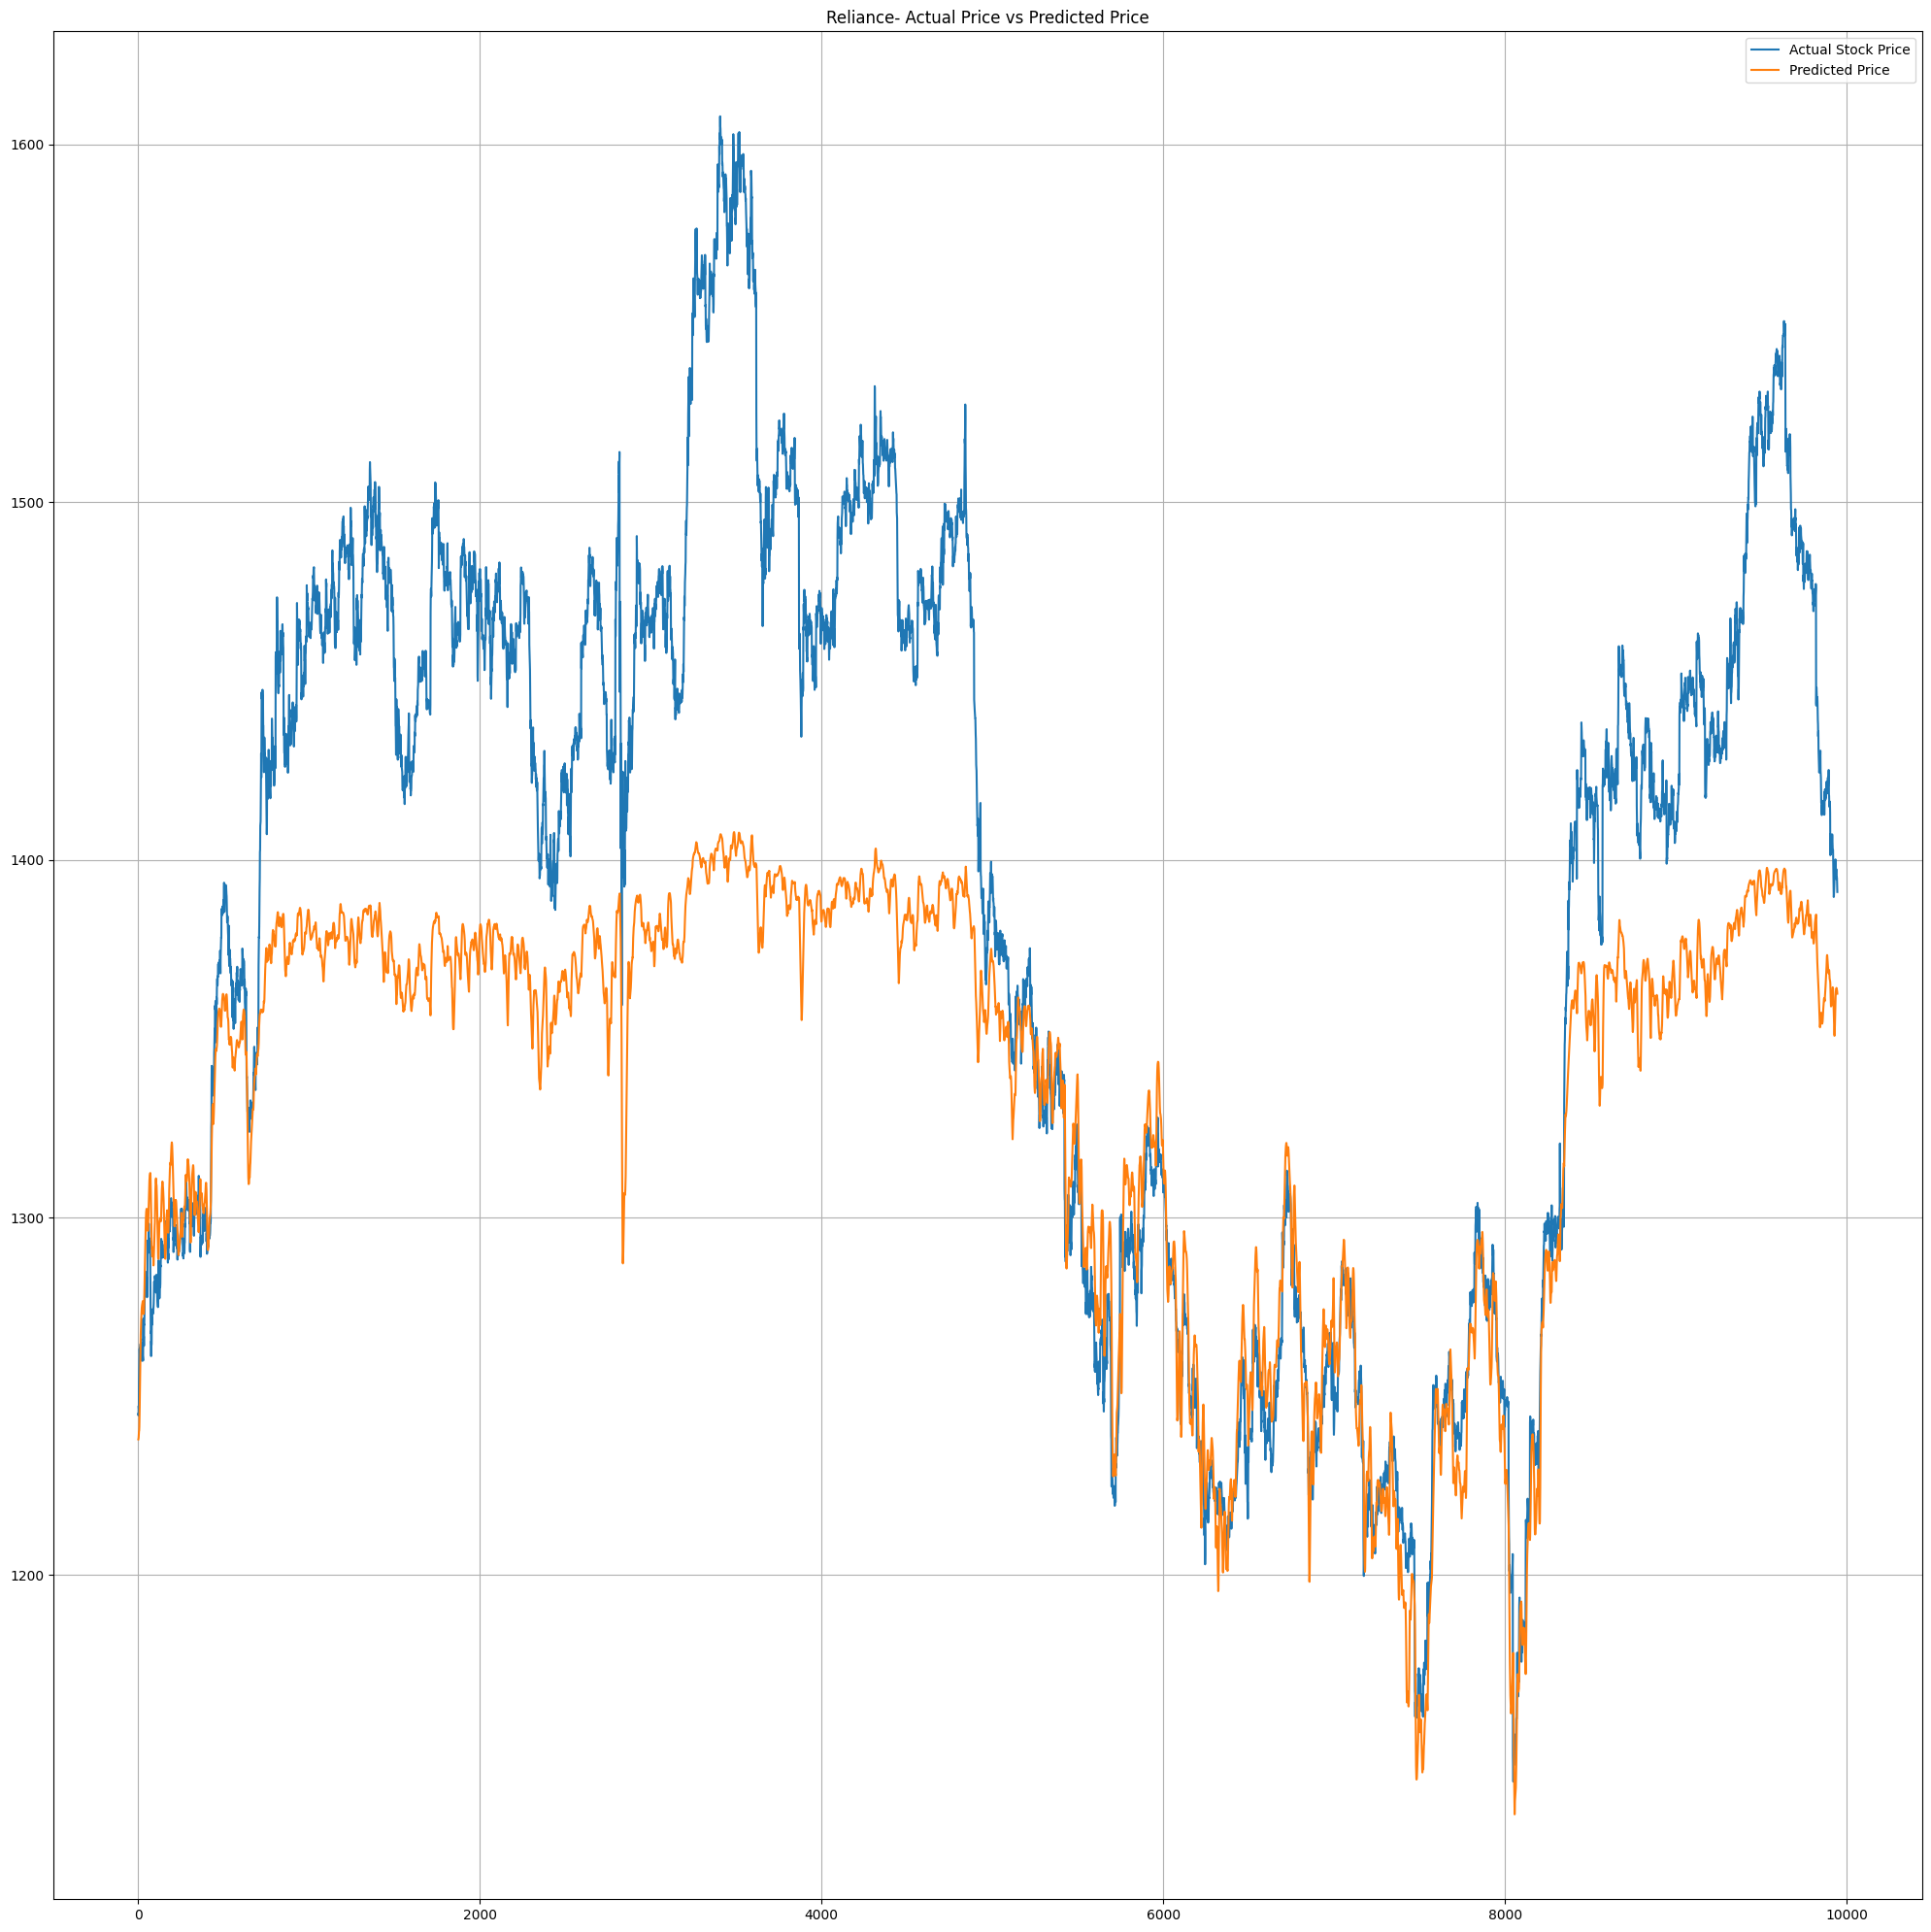

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = split_data(df_reliance)
print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1).to(device)
Y_val = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1).to(device)

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)
                                                   

trained_model = train(X_train, Y_train, X_val, Y_val)
validate(trained_model, X_test, Y_test, scaler, "Reliance")


Train and Validate with HDFC data

Using device: cuda
(34843, 10, 13) (4967, 10, 13) (9946, 10, 13)
(34843,) (4967,) (9946,)
torch.Size([34843, 10, 13]) torch.Size([4967, 10, 13]) torch.Size([9946, 10, 13])
torch.Size([34843, 1]) torch.Size([4967, 1]) torch.Size([9946, 1])
Epoch 0: Train Loss = 0.8911, Val Loss = 2.3937
Epoch 10: Train Loss = 0.7592, Val Loss = 2.0453
Epoch 20: Train Loss = 0.3791, Val Loss = 1.0641
Epoch 30: Train Loss = 0.1126, Val Loss = 0.1755
Epoch 40: Train Loss = 0.1094, Val Loss = 0.1533
Epoch 50: Train Loss = 0.0722, Val Loss = 0.2857
Epoch 60: Train Loss = 0.0433, Val Loss = 0.1851
Epoch 70: Train Loss = 0.0182, Val Loss = 0.0832
Epoch 80: Train Loss = 0.0066, Val Loss = 0.0359
Epoch 90: Train Loss = 0.0042, Val Loss = 0.0182
total MSE Loss: 0.28349707


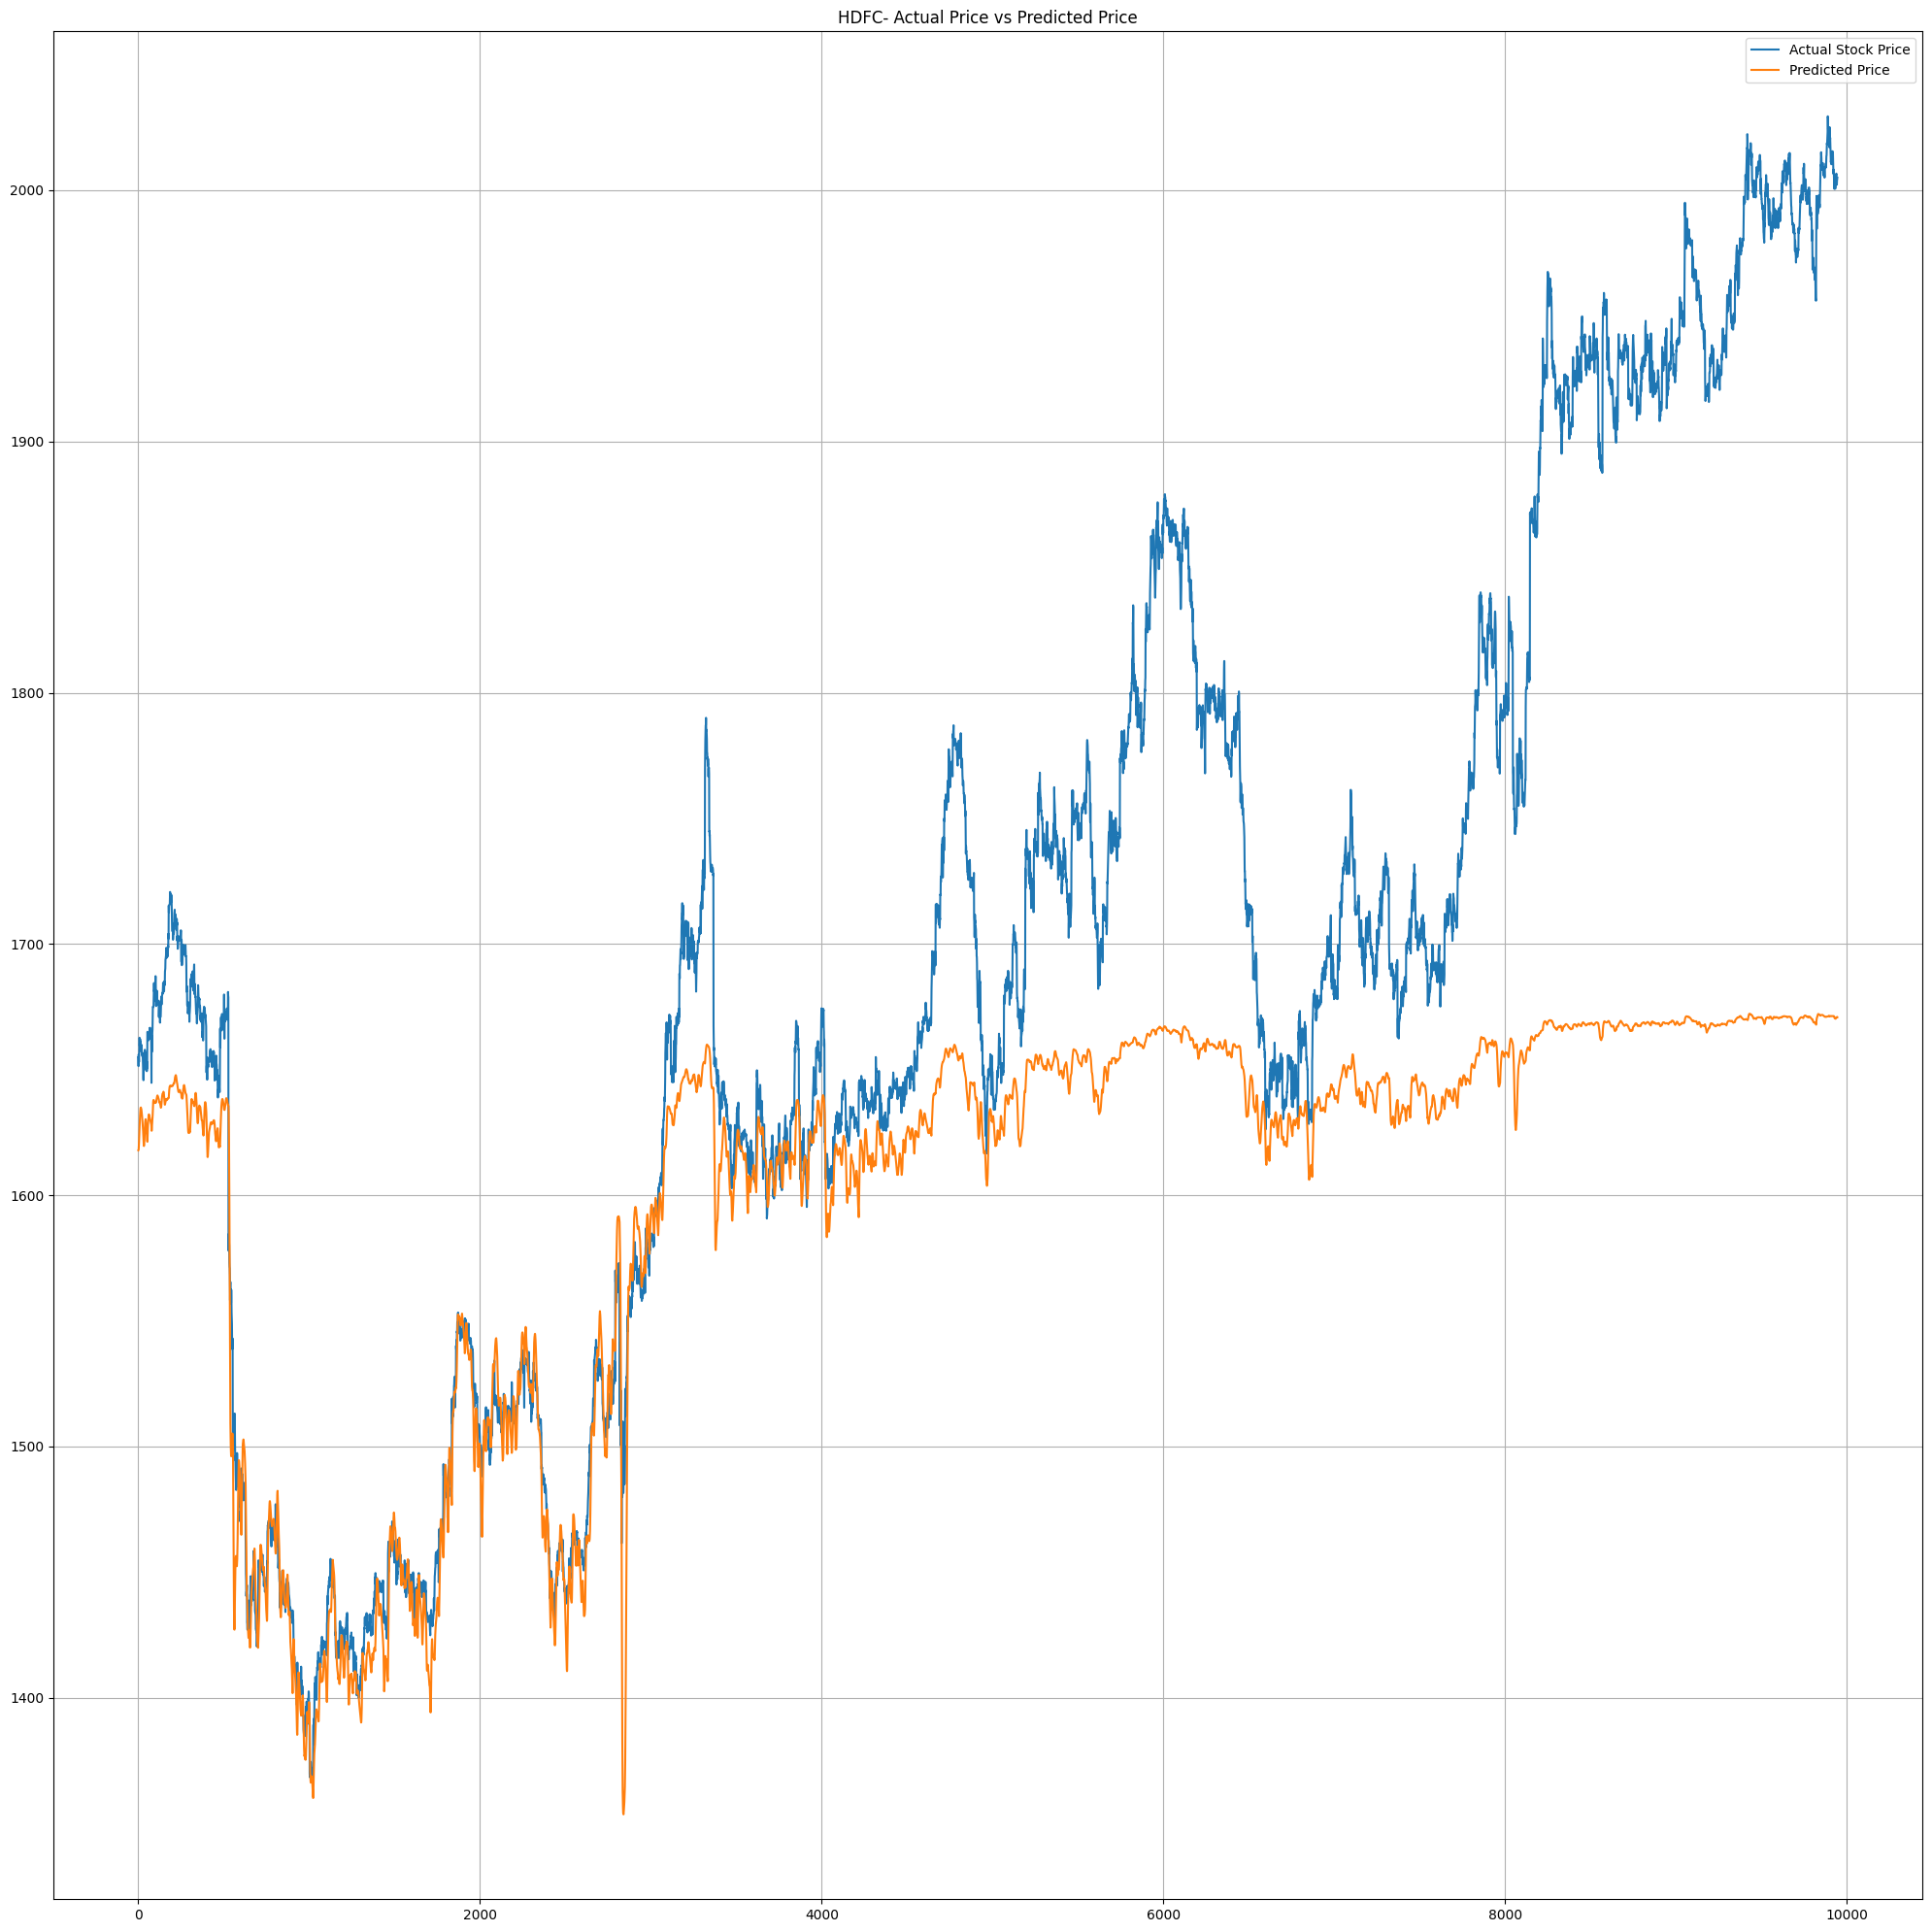

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = split_data(df_hdfc)
print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1).to(device)
Y_val = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1).to(device)

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)
                                                   

trained_model = train(X_train, Y_train, X_val, Y_val)
validate(trained_model, X_test, Y_test, scaler, "HDFC")


Now Let's predict the share price in 1D time frame

In [17]:
rel_df = generate_data("NSE:RELIANCE-EQ", "1D")
rel_df = add_ta_features(rel_df)
rel_df = add_time_features(rel_df)

print(rel_df.shape)
print(rel_df.head())

(2469, 28)
    timestamp    open    high     low   close   volume       date       EMA_5  \
0  1442534400  216.74  221.94  216.42  220.92  7935330 2015-09-18  220.920000   
1  1442793600  217.12  219.15  216.15  216.66  2948916 2015-09-21  219.500000   
2  1442880000  217.12  218.33  208.37  209.20  3646836 2015-09-22  216.066667   
3  1442966400  208.00  211.40  207.26  209.81  3525412 2015-09-23  213.981111   
4  1443052800  209.23  209.23  205.96  206.60  6734548 2015-09-24  211.520741   

        EMA_9      EMA_15  SUPERT_10_3.0  SUPERTd_10_3.0  SUPERTl_10_3.0  \
0  220.920000  220.920000            0.0               1             NaN   
1  220.068000  220.387500            NaN               1             NaN   
2  217.894400  218.989062            NaN               1             NaN   
3  216.277520  217.841680            NaN               1             NaN   
4  214.342016  216.436470            NaN               1             NaN   

   SUPERTs_10_3.0  RSI  ATR  MACD  MACD_histo

Since there is 2469 data points, we will use 2000 for training and rest for validation and testing

In [18]:
def split_data_d(df):
    final_data = df[['close','EMA_5','EMA_9','EMA_15','expiry_day','SUPERTd_10_3.0','RSI','MACD',"ATR"]]
    final_data.dropna(inplace=True)

    X = final_data.to_numpy()
    
    train_size = int(2000)
    X_train = X[:train_size,:]
    X_test = X[train_size:,:]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    remaining_columns = df[['Day sin','Day cos','Year sin',"Year sin"]].to_numpy()
    X_train = np.append(X_train,remaining_columns[25:train_size+25],axis=1)
    X_test = np.append(X_test,remaining_columns[(train_size+25):],axis=1)

    X_train, Y_train = generate_X_Y(X_train)
    X_test, Y_test = generate_X_Y(X_test)
    
    val_index = int(0.5*X_test.shape[0])
    X_val, Y_val = X_test[val_index:,:], Y_test[val_index:]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler


Now lets train and validate the model

Using device: cuda
(1990, 10, 13) (217, 10, 13) (434, 10, 13)
(1990,) (217,) (434,)
torch.Size([1990, 10, 13]) torch.Size([217, 10, 13]) torch.Size([434, 10, 13])
torch.Size([1990, 1]) torch.Size([217, 1]) torch.Size([434, 1])
Epoch 0: Train Loss = 0.9997, Val Loss = 2.5900
Epoch 10: Train Loss = 0.7963, Val Loss = 2.3606
Epoch 20: Train Loss = 0.5075, Val Loss = 2.0245
Epoch 30: Train Loss = 0.2670, Val Loss = 1.2203
Epoch 40: Train Loss = 0.1086, Val Loss = 0.5030
Epoch 50: Train Loss = 0.0713, Val Loss = 0.2067
Epoch 60: Train Loss = 0.0402, Val Loss = 0.2029
Epoch 70: Train Loss = 0.0297, Val Loss = 0.2282
Epoch 80: Train Loss = 0.0207, Val Loss = 0.1570
Epoch 90: Train Loss = 0.0128, Val Loss = 0.1247
total MSE Loss: 0.13687931


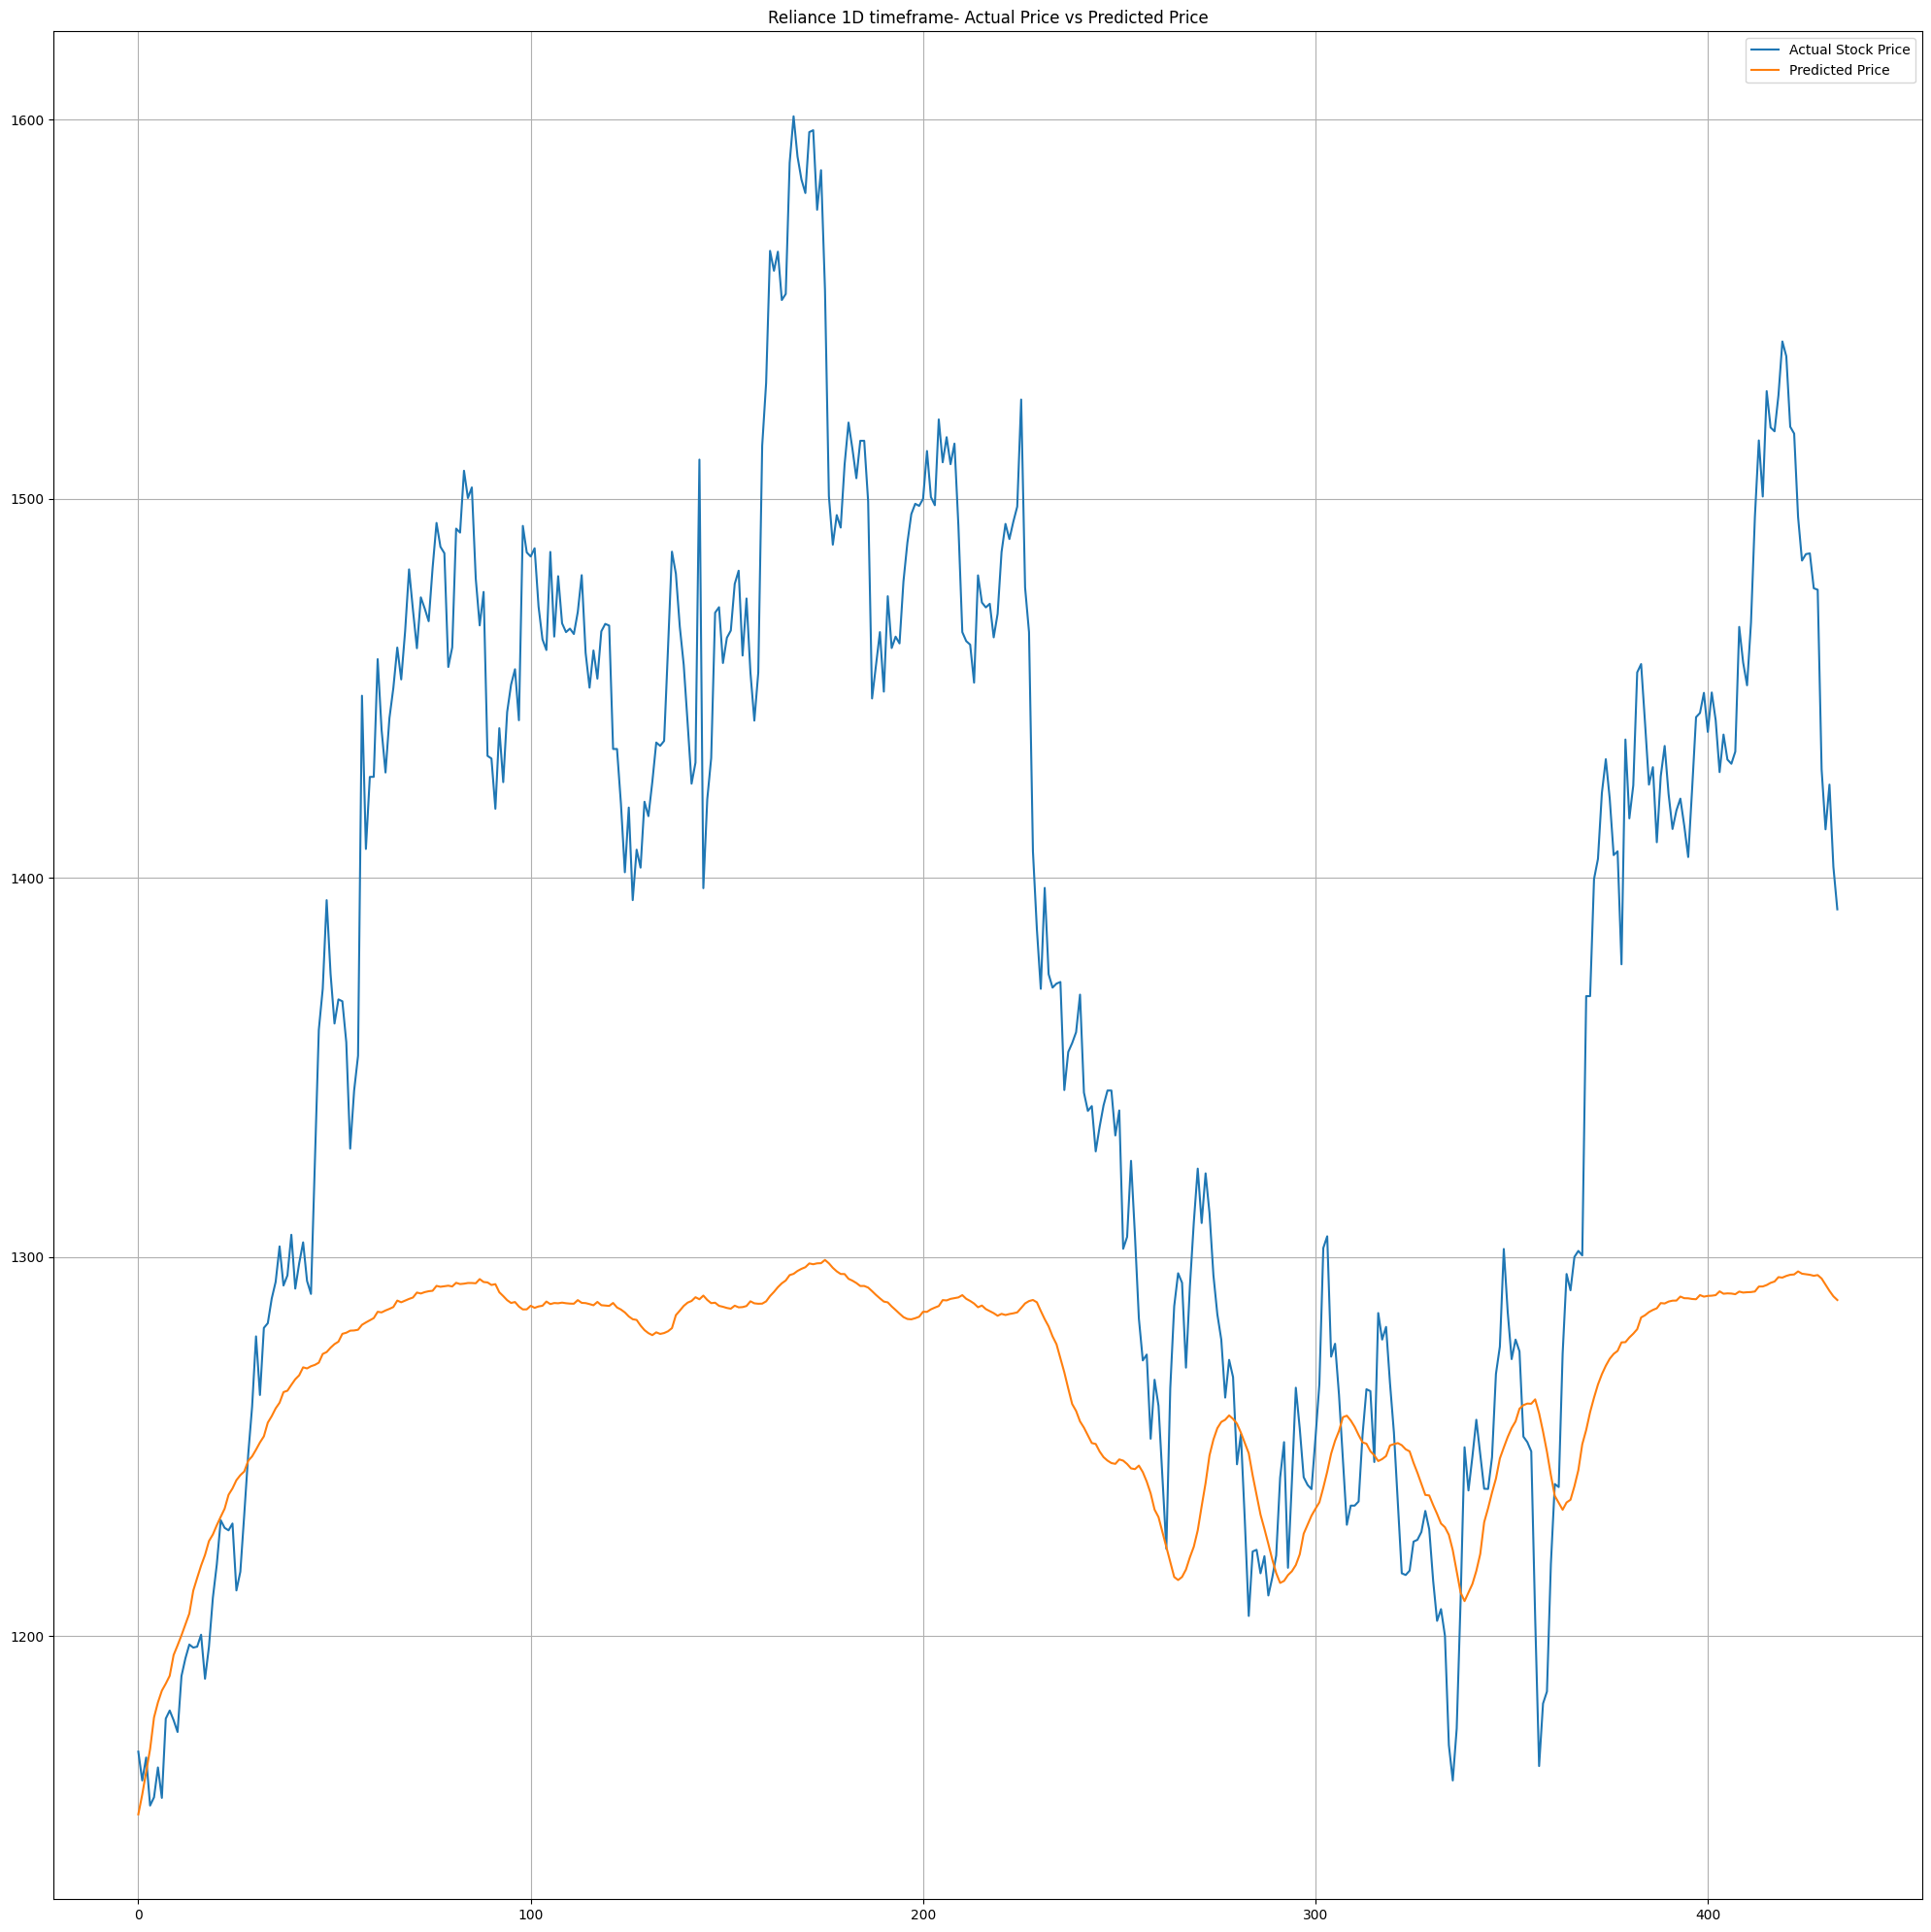

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = split_data_d(rel_df)
print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1).to(device)
Y_val = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1).to(device)

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)
                                                   

trained_model = train(X_train, Y_train, X_val, Y_val)
validate(trained_model, X_test, Y_test, scaler, "Reliance 1D timeframe")